In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Read in intermediate datasets from 02_data_normalization_and_sampling

In [3]:
# 16k prepared and cleaned hit songs
df_hits_cleaned = pd.read_csv('../data/processed/df_hits_cleaned.csv')

# 16k randomly sampled non-hit songs from prepared and cleaned non-hits dataset
non_hits_16k = pd.read_csv('../data/processed/non_hits_16k.csv')

In [4]:
df_hits_cleaned.head()

,song,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,song_artist,hit_song
0,guerrilla radio,rage against the machine,0.599,0.957,11.0,-5.764,1.0,0.1880,0.012900,0.000071,0.155,0.489,103.680,206200.0,4.0,1999,guerrilla radio_rage against the machine,1
1,leave right now,will young,0.641,0.445,6.0,-8.674,1.0,0.0368,0.145000,0.000000,0.108,0.383,81.931,214733.0,4.0,2003,leave right now_will young,1
2,let the day begin,the call,0.428,0.867,2.0,-5.051,1.0,0.0818,0.024100,0.025300,0.715,0.383,124.154,265744.0,4.0,2000,let the day begin_the call,1
3,misery,soul asylum,0.380,0.643,0.0,-8.304,1.0,0.0287,0.000049,0.000027,0.244,0.297,113.674,264360.0,4.0,1995,misery_soul asylum,1
4,promises broken,soul asylum,0.472,0.475,4.0,-11.115,1.0,0.0311,0.138000,0.000003,0.113,0.718,150.611,194587.0,4.0,1995,promises broken_soul asylum,1


# 7. Correlation Matrix of Audio Features

## Hit songs correlation

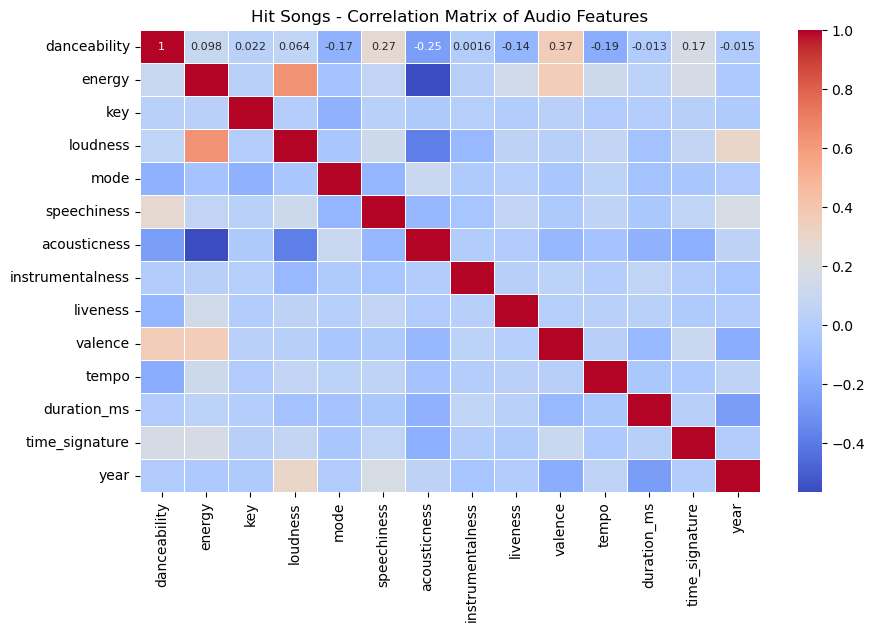

In [6]:
num_data = df_hits_cleaned.drop(['song','artist', 'song_artist', 'hit_song'], axis=1)

correlation_matrix = num_data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.4, annot_kws={"size": 8})
plt.title('Hit Songs - Correlation Matrix of Audio Features')
plt.show()

#### Evaluation of audio features correlation - hit songs
Loudness and energy are highly correlated, acousticness has a high negative correlation with both loudness and energy

## Non-hit songs correlation

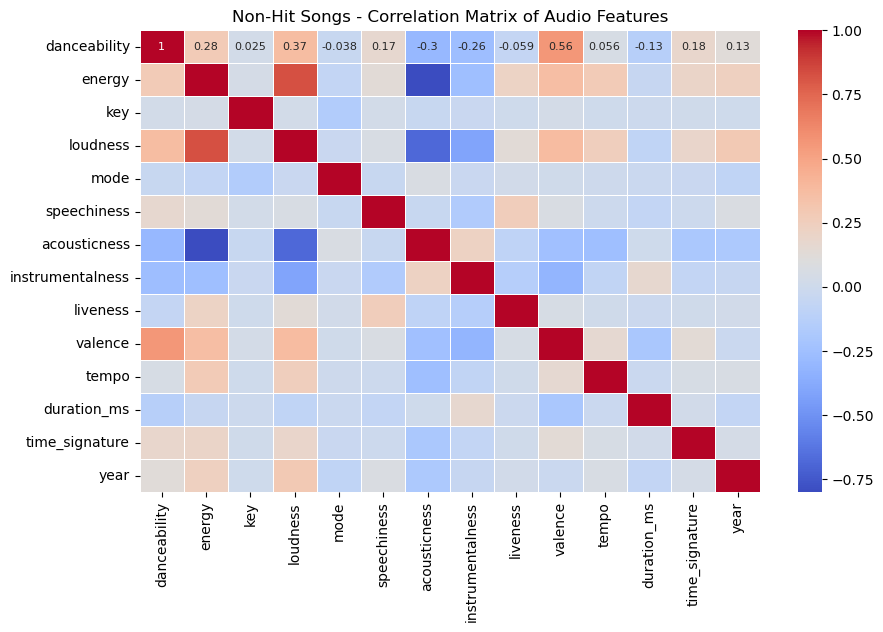

In [7]:
num_data = non_hits_16k.drop(['song','artist', 'song_artist', 'hit_song'], axis=1)

correlation_matrix = num_data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.4, annot_kws={"size": 8})
plt.title('Non-Hit Songs - Correlation Matrix of Audio Features')
plt.show()

#### Evaluation of audio features correlation - hit songs
Loudness and energy are highly correlated as well as valence and danceability. Acousticness has a very high negative correlation with both loudness and energy

# 8. Audio Feature Distribution Comparison Between Hit and Non-Hit Songs

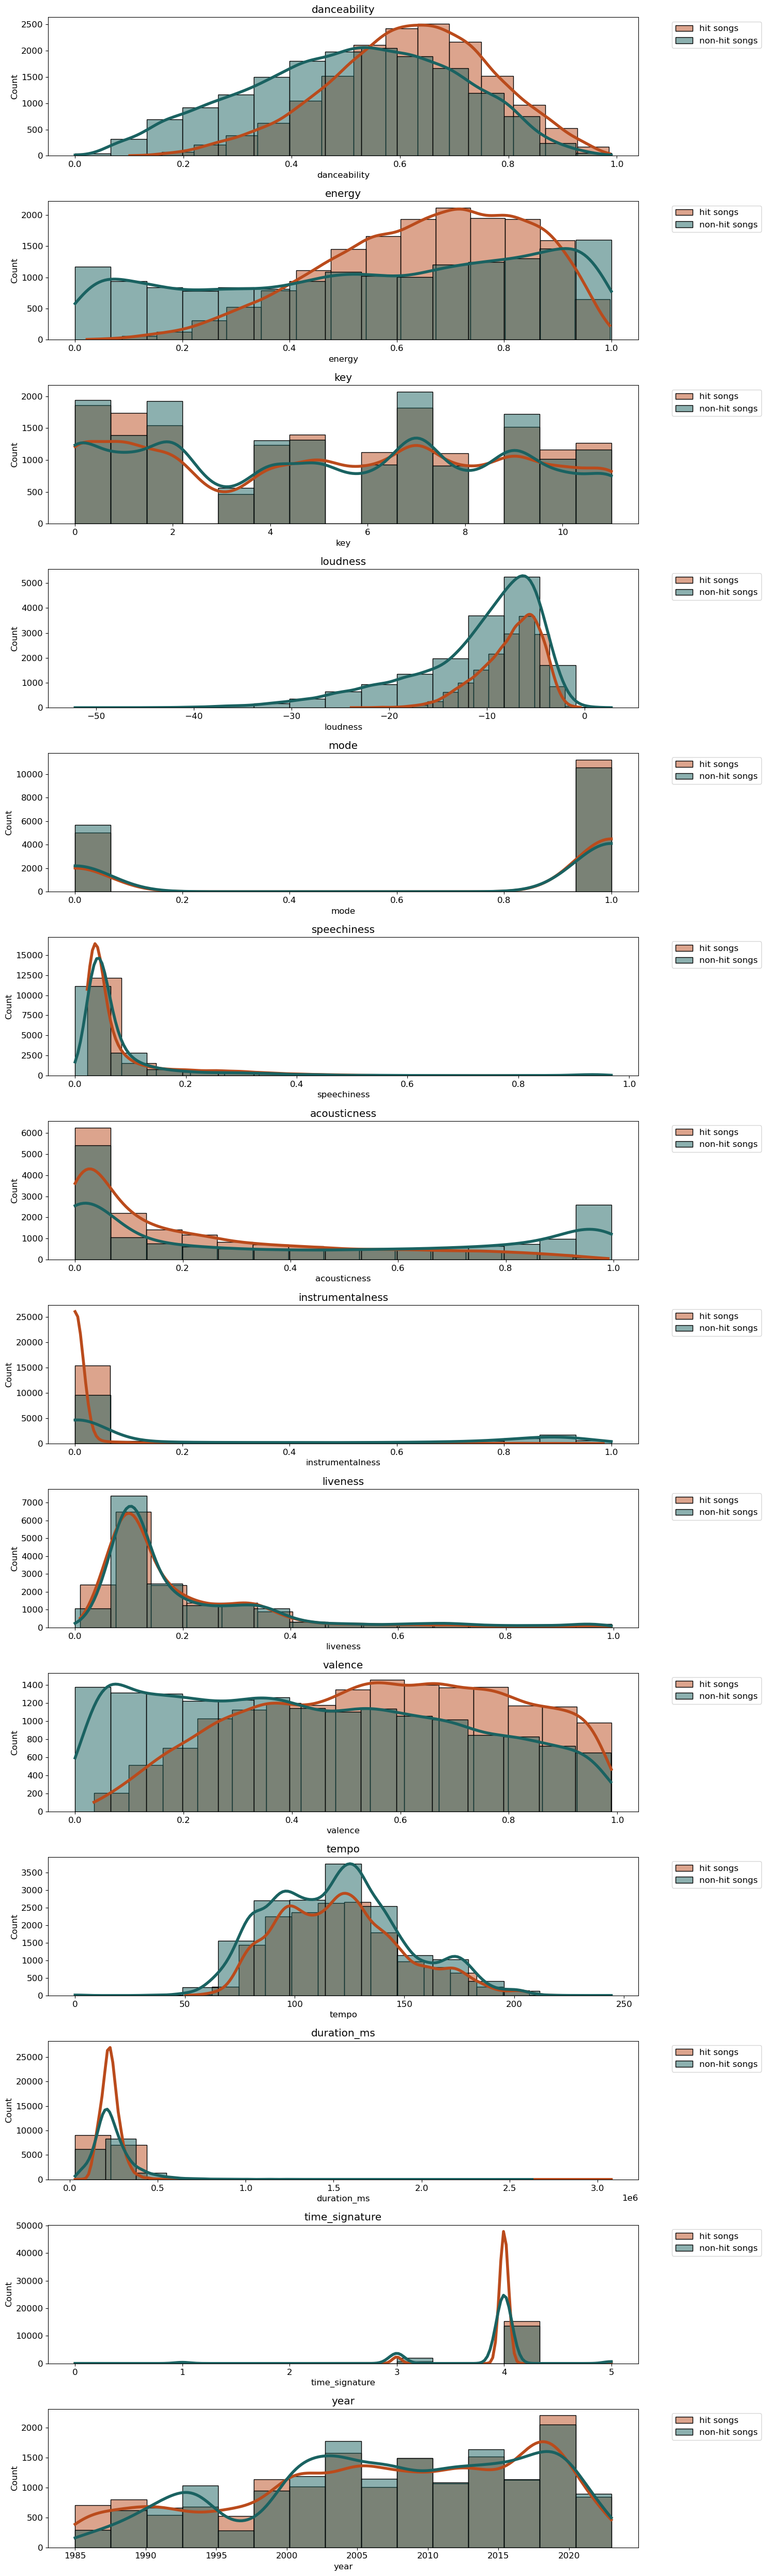

In [13]:
# Plot and compare distributions of audio features from hit and non-hit song datasets
features = df_hits_cleaned[['danceability','energy', 'key', 'loudness', 'mode','speechiness', 'acousticness', 'instrumentalness',
                    'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'year']]

plt.figure(figsize=(15, 50))
plt.rcParams['font.size'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['text.color'] = 'black' 

# Loop through each feature and create a subplot
for i, feature in enumerate(features, 1):
    plt.subplot(14, 1, i)
    sns.histplot(df_hits_cleaned[feature], bins=15, kde=True, color='#ba4b1c', alpha=0.5, label='hit songs',
                 line_kws={'color': '#ba4b1c', 'lw': 4})
    sns.histplot(non_hits_16k[feature], bins=15, kde=True, color= '#1a6261', alpha=0.5, label='non-hit songs',
                 line_kws={'color': '#1a6261', 'lw': 4})
    plt.title(feature)
    plt.legend()
    plt.legend(loc='upper right', framealpha=0.5, fontsize='medium') 
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Preliminary evaluation of features of modeling (analysis of histogram distributions)

#### Top 100 hits + random non-hits dataset creation:
- minimum year - 2.3 million song dataset is heavily skewed towards songs after 2000, barely anything before 1985. Billboard Top 100 was more evenly spread from 1960s to present. (filtering decision: minimum year set to 1985, 16.2k hit songs total)
- distribution of years - 2.3 million song dataset is heavily skewed towards songs after 2000, barely anything before 1985. Billboard Top 100 is ~35% songs from 1985-2004 and 65% songs from 2005-2023. (filtering decision: distribution of randomly selected 16.2k songs by 25% 1985-1999 and 75% 2000-2023 to most closely match distribution of hit songs)

#### features to definitely explore:
- danceability - Top 100 slight peak shift to the right, differentiated trend from non-hits
- energy - Top 100 larger peak shifted right while non-hits are more evenly distributed
- valence - Top 100 and non-hits essentially have opposite distributions/peaks with hit songs trending to the right. There is a lot of overlap here though

#### features to explore with less emphasis:
 - loudness - Top 100 much tighter range compared to non-hits, not primary focus but could be good add-on feature
 - speechiness - Top 100 is very tight lower range, non-hits also skew lower but have a bit more distribution, not primary focus but could be good add-on feature
 - instrumentalness - Top 100 all at low end, literally no variation. non-hits also favor low end but has an overall wider dsitribution of values
 - acousticness - Non-hit songs have a peak similar to Top 100 songs at the low end, but also a peak at the other extreme (high levels of acoustics)

#### low priority features:
 - duration
 - time signature
 - tempo
 - liveness
 - mode
 - key

# 9. Time Series Analysis

In [14]:
# Consolidate the hit and non-hit songs into one dataset
data = pd.concat([df_hits_cleaned, non_hits_16k], ignore_index=True)

In [15]:
# Drop non-numeric columns if needed
data_numeric = data.drop(['song', 'artist', 'song_artist'], axis=1)

In [16]:
data_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32484 entries, 0 to 32483
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      32484 non-null  float64
 1   energy            32484 non-null  float64
 2   key               32484 non-null  float64
 3   loudness          32484 non-null  float64
 4   mode              32484 non-null  float64
 5   speechiness       32484 non-null  float64
 6   acousticness      32484 non-null  float64
 7   instrumentalness  32484 non-null  float64
 8   liveness          32484 non-null  float64
 9   valence           32484 non-null  float64
 10  tempo             32484 non-null  float64
 11  duration_ms       32484 non-null  float64
 12  time_signature    32484 non-null  float64
 13  year              32484 non-null  int64  
 14  hit_song          32484 non-null  int64  
dtypes: float64(13), int64(2)
memory usage: 3.7 MB


(3.0, 4.5)

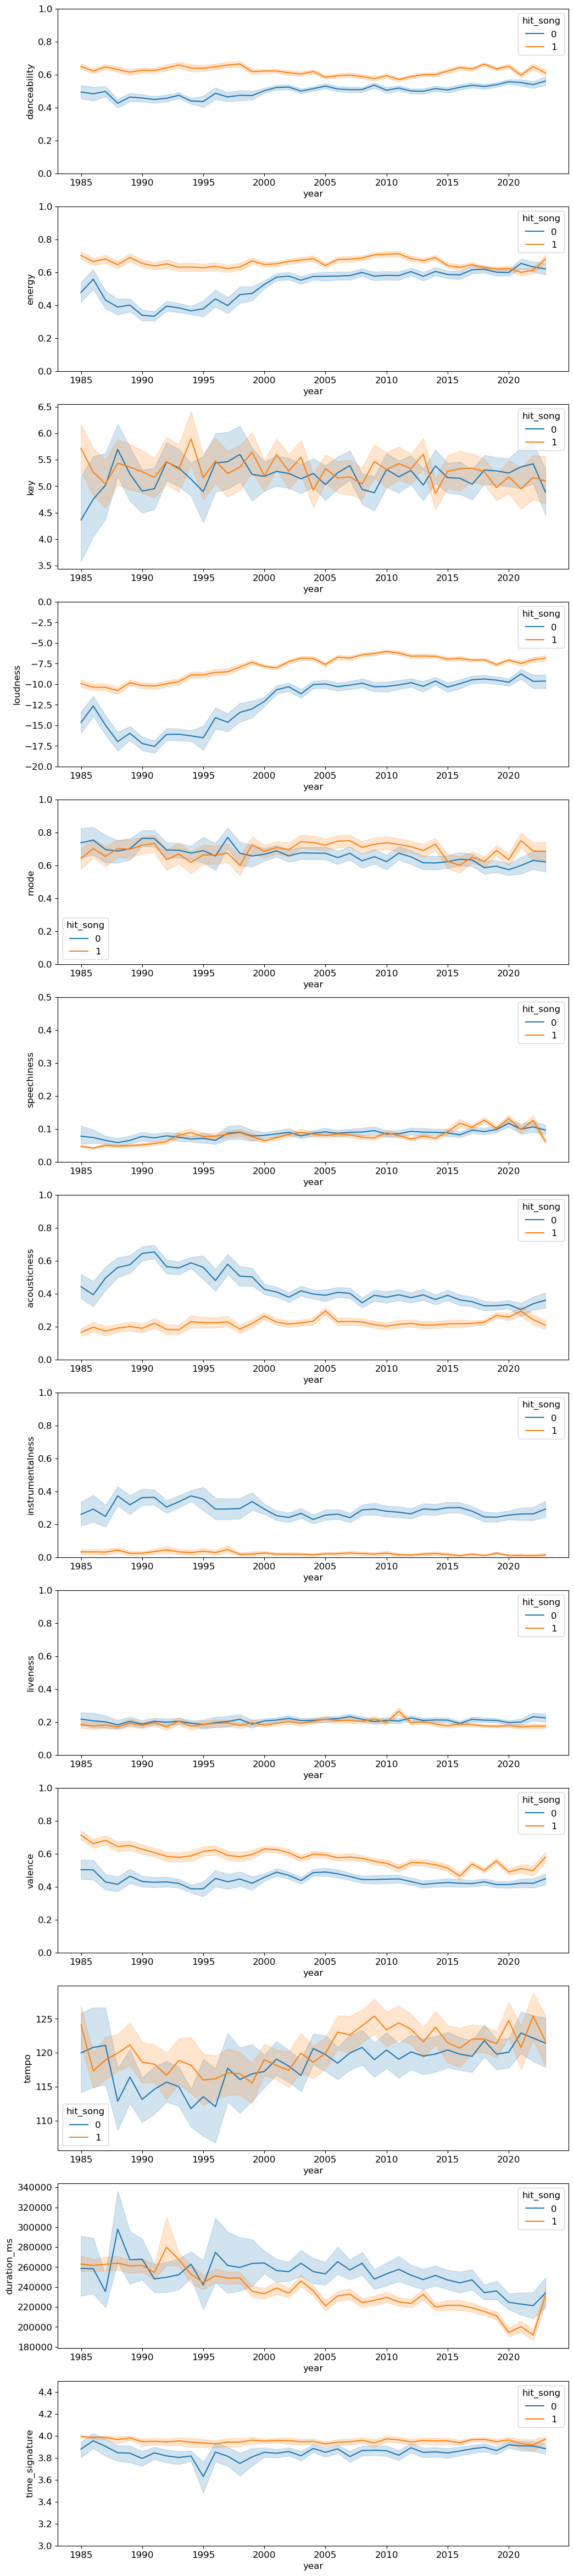

In [36]:
fig, axes = plt.subplots(13,1, figsize=(12,60))

sns.lineplot(data=data, x='year', y='danceability', hue='hit_song', ax=axes[0] )
axes[0].set_ylim(0, 1)
sns.lineplot(data=data, x='year', y='energy', hue='hit_song', ax=axes[1])
axes[1].set_ylim(0, 1)
sns.lineplot(data=data, x='year', y='key', hue='hit_song', ax=axes[2])
sns.lineplot(data=data, x='year', y='loudness', hue='hit_song', ax=axes[3])
axes[3].set_ylim(-20, 0)
sns.lineplot(data=data, x='year', y='mode', hue='hit_song', ax=axes[4])
axes[4].set_ylim(0, 1)
sns.lineplot(data=data, x='year', y='speechiness', hue='hit_song', ax=axes[5])
axes[5].set_ylim(0, 0.5)
sns.lineplot(data=data, x='year', y='acousticness', hue='hit_song', ax=axes[6])
axes[6].set_ylim(0, 1)
sns.lineplot(data=data, x='year', y='instrumentalness', hue='hit_song', ax=axes[7])
axes[7].set_ylim(0, 1)
sns.lineplot(data=data, x='year', y='liveness', hue='hit_song', ax=axes[8])
axes[8].set_ylim(0, 1)
sns.lineplot(data=data, x='year', y='valence', hue='hit_song', ax=axes[9])
axes[9].set_ylim(0, 1)
sns.lineplot(data=data, x='year', y='tempo', hue='hit_song', ax=axes[10])
sns.lineplot(data=data, x='year', y='duration_ms', hue='hit_song', ax=axes[11])
sns.lineplot(data=data, x='year', y='time_signature', hue='hit_song', ax=axes[12])
axes[12].set_ylim(3, 4.5)

## Time Series Preliminary Analysis

### Top 100 songs
The Billboard Top 100 songs have remained relatively consistent across all audio features

### Non-hit songs
The non-hit songs dataset is quite interesting - there seems to be a trend starting around the year 2000 where certain features (loudness, energy, acousticness, valence) begin to align more closely with trends seen in the hit songs dataset. This will be a great question to follow-up with clustering to see if well-defined groups are defined following the identified trends

## Creation of final combined dataset :
- modeling_dataset_32k: 32,000 total songs (16k hits and 16k non-hits). Dataset is merged, cleaned, sampled and ready for modeling

In [38]:
data.to_csv('../data/final/modeling_dataset_32k.csv', index=False)